# ThermoGan

**Author** - [Lukas Vlcek](https://https://github.com/vlcekl)

**thermoGAN** is designed keeping a high degree of extensibility in mind, and allows you to write custom loss functions of your own without having to rewrite the entire training and evaluation loop. This can be done by extending the ```torchgan.losses.GeneratorLoss``` or the ```torchgan.losses.DiscriminatorLoss``` object. 

All **TorchGAN** losses have a ```train_ops``` associated with it that dictates what steps are to be followed for the loss to be computed and backpropagated. By default, most of the ```train_ops``` follow a **Two Timescale Update Rule (TTUR) ** as follows

1. Sample a noise vector from a Normal Distribution $z \sim \mathcal{N}(0,\,1)$
3. $d_{real} = D(x)$
4. $d_{fake} = D(G(z))$
5. $\mathcal{L} = Loss(d_{real}, d_{fake})$  (*for a Generator Loss $d_{real}$ is generally not computed*)
6. Backpropagate over $\mathcal{L}$

Where 
* $x$ is a sample from the Data Distribution
* $D$ is the Discriminator Network
* $G$ is the Generator Network

Simple losses that conform to this kind of an update rule can be easily implemented by overriding the ```forward``` method of the ```GeneratorLoss``` or ```DiscriminatorLoss``` object

** *NB: It is highly recommended that you go over the Introduction to TorchGAN Tutorial before reading this* *

## WRITING CUSTOM LOSSES THAT FOLLOW THE STANDARD UPDATE RULE

We shall demonstrate this by implementing the [Boundary Seeking GAN by Hjelm et. al.](https://arxiv.org/abs/1702.08431), also known as BGAN
BGAN involves a departure from the Minimax Loss by changing the Generator Loss term in the following manner

$$ \mathcal{L_{generator}} = \frac{1}{2}E_{z \sim p(z)}[(log(D(G(z))) - log(1 - D(G(z))))^2]$$

where

* $z$ is the noise sampled from a probability distribution
* $D$ is the Discriminator Network
* $G$ is the Generator Network

We can observe that the update rule for such a loss confirms with the Standard Update Rule used in **TorchGAN**, hence this loss can be implemented simply by extending the ```torchgan.losses.GeneratorLoss``` object and overriding the ```forward``` method

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# General Imports
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pytorch and Torchvision Imports
import torch
from torch.optim import Adam
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Torchgan Imports
#import torchgan
from torchgan.losses import GeneratorLoss, MinimaxDiscriminatorLoss
from torchgan.trainer import Trainer

ModuleNotFoundError: No module named 'torchgan'

In [3]:
from torch.nn.functional import pad, depad

# My source code for TGAN model
sys.path.append('../src')
from tgan.model import TGANGenerator, TGANDiscriminator

In [4]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## Loading the 2D Ising model configurations generated in MC simulation

1. The size of the configurations is assumed (k, k) with k power of 2
2. Currently uses 4x4 kernel with no padding (in future it should be 3x3 kernel with cyclic padding)

In [5]:
data_dir = '../data'
sim_dir = '../sim/maxi'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']  # ferromagnetic
temps.extend(['a1', 'a2', 'a5', 'a10', 'a20', 'a100'])  # antiferromagnetic

In [6]:
def read_xyz_lattice(filename, type_map=None):
    """
    Reads lattice xyz file

    Parameters
    ----------
    filename: str
              full path and name of the xyz file

    Returns
    -------
    latt: ndarray(n, lx, ly, lz)
          trajectory n lattice configurations of dimensions (lx,ly,lz)
    """

    with open(filename, 'r') as fc:

        cfgs = []

        for line in iter(fc.readline, ''):
            nat = int(line.strip().split()[0])

            box = tuple(map(int, fc.readline().strip().split()))[0:3]
            cfg = np.zeros(box, dtype=int)
            
            # fill lattice with atom types
            for i in range(nat):
                sarr = fc.readline().strip().split()
                ti = int(sarr[0])
                x, y, z = [int(x) for x in sarr[1:4]]
                if type_map:
                    cfg[x-1, y-1, z-1] = type_map[ti]
                else:
                    cfg[x-1, y-1, z-1] = ti

            cfgs.append(cfg)

    return cfgs

In [7]:
# local library for data processing

class IsingDataset(Dataset):
    """ Dataset class sublcassed from torch's dataset utility
    Parameters
    ----------
    path: str
        path to directory with class folders
    """

    def __init__(self, path, traj_file, labels=None, start=0, end=None, label_encode='onehot'):

        if labels is None:
            labels = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            
        all_cfgs = []
        all_labels = []
        for label in labels:
            cfg_dir = os.path.join(path, label)
            cfgs = read_xyz_lattice(os.path.join(cfg_dir, traj_file), type_map={-1:0, 1:1})
            # Take only one layer perpendicular to z-direction (Assumes 2D model)
            all_cfgs.extend([cfg[:,:,0] for cfg in cfgs[start:end]])
            all_labels.extend([label]*len(cfgs[start:end]))
        
        self.X = torch.FloatTensor(np.array(all_cfgs))
        
        # One-hot encoding of the target labels
        if label_encode == 'onehot':
            self.y = self._get_onehot(all_labels)
        else:
            self.y = torch.FloatTensor(np.array(all_labels))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
    def _get_onehot(self, labels):
        labels = list(labels)
        batch_size = len(labels)
        unique_labels = sorted(list(set(labels)))
        n_classes = len(unique_labels)
    
        # convert labels to numbers from 0 to n_classes-1
        labels_id = [unique_labels.index(label) for label in labels]
        labels_id = np.reshape(labels_id, (batch_size, -1))
        labels_id = torch.LongTensor(labels_id)
    
        onehot = torch.FloatTensor(batch_size, n_classes)
        onehot.zero_()
        onehot.scatter_(1, labels_id, 1)
        return onehot

In [8]:
dataset = IsingDataset(sim_dir, traj_file='lg.xyz', labels=['a2'], start=1001)
print('a2', dataset[3000:3002])
# print('a5', dataset[7000:7002])
# print('t1', dataset[11000:11002])
# print('t10', dataset[15000:15002])

a2 (tensor([[[0., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 1., 1.],
         [1., 0., 1.,  ..., 1., 0., 1.]],

        [[0., 1., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 1.,  ..., 1., 0., 1.],
         [1., 0., 1.,  ..., 0., 1., 0.],
         [1., 1., 0.,  ..., 1., 0., 1.]]]), tensor([[1.],
        [1.]]))


In [9]:
len(dataset), dataset[0][0].shape

(4000, torch.Size([32, 32]))

Samples 4000
Minibatches: 32


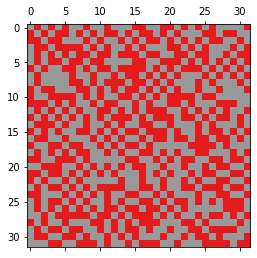

In [60]:
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("Samples", len(dataset))
print("Minibatches:", len(dataloader))
# for batch in dataloader:
#     print(batch[0].shape)
    
plt.matshow(dataset[-2000][0], cmap='Set1')

## Model definition

In [ ]:
feature_dim = 16

In [51]:
generator_params = {
    'encoding_dims': feature_dim,
    'out_size': dataset[0][0].shape[0],
    'out_channels': 1,
    'step_channels': 2,
    'batchnorm': False,
    'last_nonlinearity': nn.Sigmoid()
}

netG = TGANGenerator(**generator_params).to(device)

In [52]:
discriminator_params = {
    'decoding_dims': feature_dim,
    'in_size': dataset[0][0].shape[0],
    'in_channels': 1,
    'step_channels': 2,
    'batchnorm': False,
    'last_nonlinearity': nn.Sigmoid()
}

netD = TGANDiscriminator(**discriminator_params).to(device)

## Model initialization

In [53]:
# Device setup 
if torch.cuda.is_available():
    on_cuda = True
    device = torch.device("cuda:0")
    torch.backends.cudnn.deterministic = True
    print("Will run on GPU")
else:
    on_cuda = False
    device = torch.device("cpu")
    print("Will run on CPU")
    
negG = netG.to(device)
negD = netD.to(device)

Will run on CPU


In [54]:
# Model custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [55]:
print('======== GENERATOR =========')
netG.apply(weights_init)

======== GENERATOR =========


TGANGenerator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
      (1): CircularDepad2d((0, 1, 0, 1))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2))
      (1): CircularDepad2d((0, 1, 0, 1))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(4, 2, kernel_size=(3, 3), stride=(2, 2))
      (1): CircularDepad2d((0, 1, 0, 1))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): ConvTranspose2d(2, 1, kernel_size=(3, 3), stride=(2, 2))
      (1): CircularDepad2d((0, 1, 0, 1))
      (2): Sigmoid()
    )
  )
)

In [56]:
print('======== DISCRIMINATOR =========')
netD.apply(weights_init)

======== DISCRIMINATOR =========


TGANDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): CircularPad2d((0, 1, 0, 1))
      (1): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): CircularPad2d((0, 1, 0, 1))
      (1): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): CircularPad2d((0, 1, 0, 1))
      (1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): CircularPad2d((0, 1, 0, 1))
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (disc): Sequential(
    (0): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): Sigmoid()
  )
)

## Optimization setup

In [57]:
# Loss function setup
loss = nn.BCELoss()

In [58]:
# optimizer setup
lr = 0.001
betas = (0.5, 0.999)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=betas)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=betas)

In [59]:
# epoch setup
if on_cuda:
    n_epochs = 100
else:
    n_epochs = 10

In [34]:
# Auxiliary data 
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0


for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):

        #######################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #######################
        netD.zero_grad()
        
        # train with real
        real_data = data[0].to(device)
        output = netD(real_data)

        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        errD_real = loss(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, feature_dim, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake.detach())
        
        label.fill_(fake_label)

        errD_fake = loss(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Total loss and optimize D
        errD = errD_real + errD_fake
        optimizerD.step()

        #######################
        # (2) Update G network: maximize log(D(G(z)))
        #######################
        netG.zero_grad()
        
        output = netD(fake)

        label.fill_(real_label)  # fake labels are real for generator cost
        
        errG = loss(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        # optimize G
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

NameError: name 'opt' is not defined

## DEFINING THE BOUNDARY SEEKING LOSS

As discussed above, the Boundary Seeking Loss is implementing by overriding the ```forward``` pass of the Generator Loss without requiring any modifications to the ```train_ops```. 

The ```forward``` method receives the object $d_{fake} = D(G(z))$ as a parameter, where $G$ is the Generator Network, $D$ is the Discriminator Network and $z$ is a sample from the Noise Prior.


*NB: This example shall be using the standard DCGAN Generator and Discriminator available in ```torchgan.models```. By default, the last layer of the discriminator does not apply a Sigmoid nonlinearity, the reasson for which has already been discussed in the **Introduction to TorchGAN** tutorial. As a result, the nonlinearity is applied within the loss by a call to ```torch.sigmoid```. One can also alternatively omit this and set the ```last_nonlinearity``` property of the DCGAN Discriminator to ```torch.nn.Sigmoid``` *

In [ ]:
class BoundarySeekingLoss(GeneratorLoss):
    def forward(self, dx):
        dx = torch.sigmoid(dx)
        return 0.5 * torch.mean((torch.log(dx) - torch.log(1.0 - dx)) ** 2)

As per the paper, only the Generator Loss is modified. Hence we will use one of the predefined losses, **MinimaxDiscriminatorLoss** for the Discriminator.

In [ ]:
losses = [BoundarySeekingLoss(), MinimaxDiscriminatorLoss()]

## MODEL CONFIGURATION

We shall now be defining the neural networks for the discriminator and generator and also set up their respective optimizers. For understanding how to do this please refer to the previous set of tutorials.

It should be noted that we have modified the Discriminator Output to use a **nn.Sigmoid** to conform with our Loss Function.

In [ ]:
network_config = {
    "generator": {"name": DCGANGenerator,
                  "args": {"out_channels": 1, "step_channels": 8},
                  "optimizer": {
                      "name": Adam,
                      "args": {"lr": 0.0001, "betas": (0.5, 0.999)}
                  }
                 },
    "discriminator": {"name": DCGANDiscriminator,
                      "args": {"in_channels": 1, "step_channels": 8},
                      "optimizer": {
                          "name": Adam,
                          "args": {"lr": 0.0001, "betas": (0.5, 0.999)}
                      }
                     }
}

## VISUALIZE THE TRAINING DATA

In [ ]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## TRAINING BGAN

Now we shall start the training. First we need to create the **Trainer** object. When creating this object all the necessary neural nets and their optimizers get instantiated.

In [ ]:
trainer = Trainer(network_config, losses, ncritic=5, epochs=epochs, sample_size=64, device=device)

In [ ]:
trainer(dataloader)

## VISUALIZING THE GENERATED IMAGES

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, 280)))
plt.show()